
Processing GLD

Performance by Scenario:
           Large_Move  Small_Move  High_Volatility  Low_Volatility
Accuracy     0.541850    0.516086         0.542977        0.510460
Precision    0.558511    0.512618         0.545692        0.510588
Recall       0.833333    0.862069         0.826087        0.893004
F1 Score     0.668790    0.642928         0.657233        0.649701


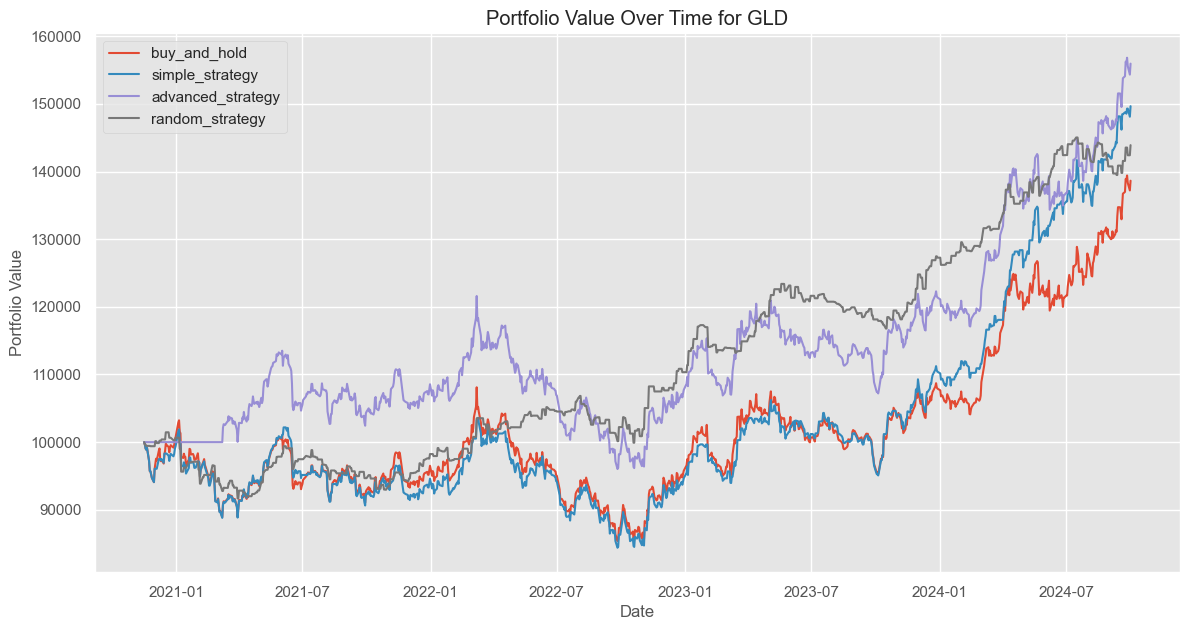


Processing SPY

Performance by Scenario:
           Large_Move  Small_Move  High_Volatility  Low_Volatility
Accuracy     0.542857    0.541126         0.528302        0.554393
Precision    0.547794    0.537994         0.525959        0.556263
Recall       0.967532    0.961957         0.939516        0.984962
F1 Score     0.699531    0.690058         0.674385        0.710991


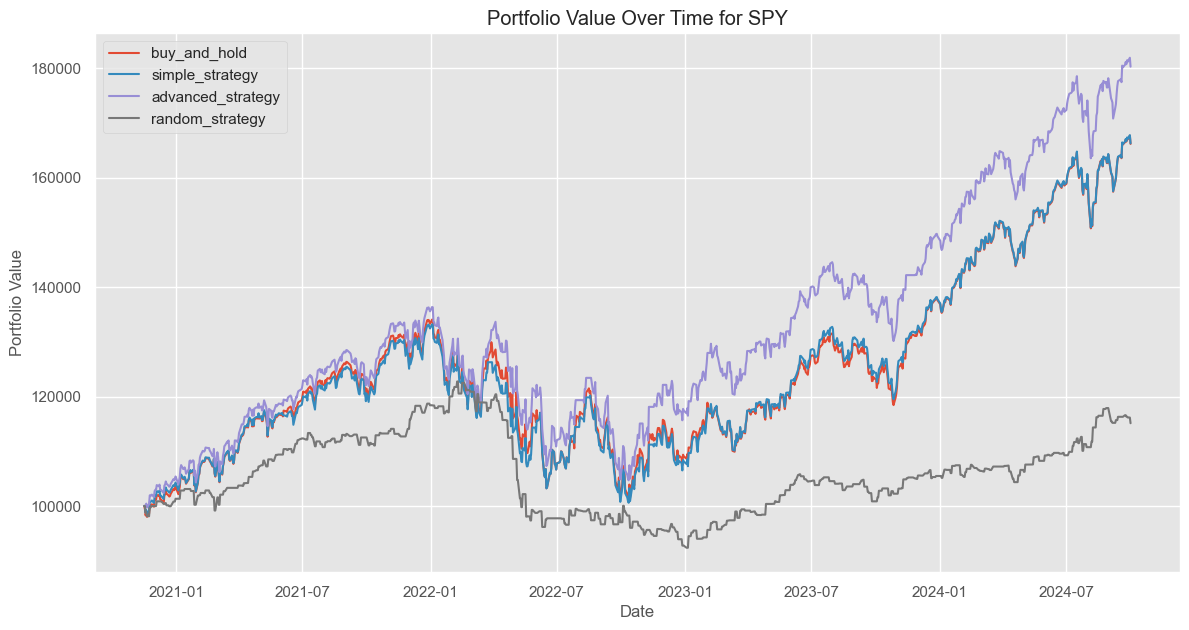


Processing BTC-USD

Performance by Scenario:
           Large_Move  Small_Move  High_Volatility  Low_Volatility
Accuracy     0.554987    0.465839         0.538905        0.500000
Precision    0.588785    0.427027         0.568627        0.482906
Recall       0.594340    0.544828         0.480663        0.680723
F1 Score     0.591549    0.478788         0.520958        0.565000


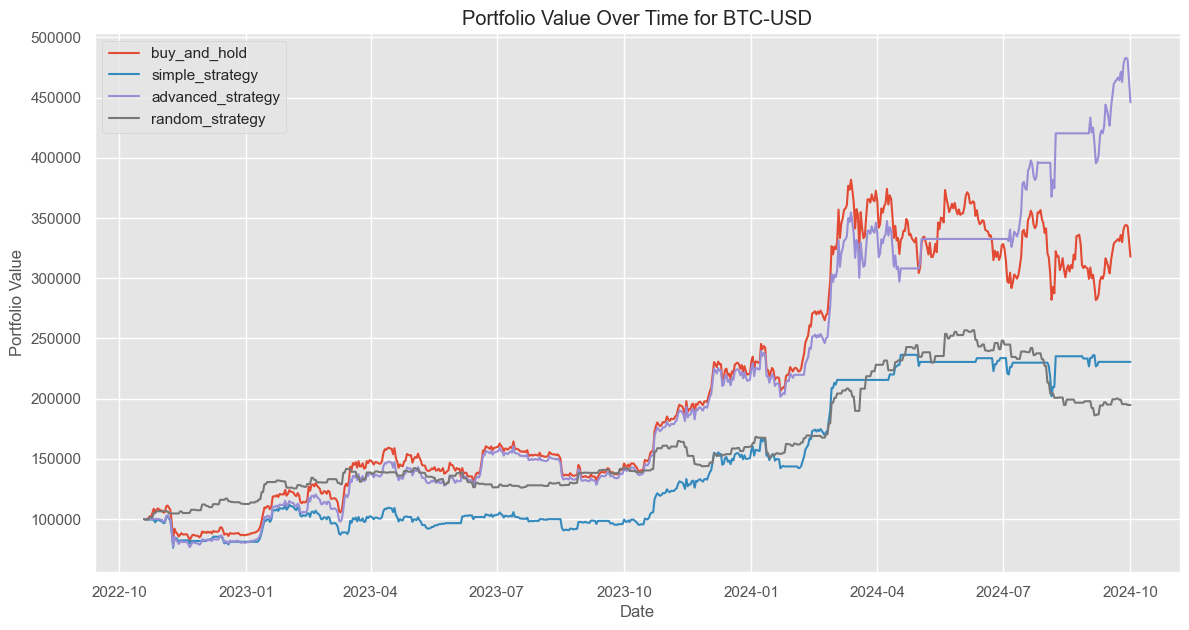


Performance Metrics for All Tickers and Strategies:


,Ticker,Strategy,Cumulative Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
0,GLD,buy_and_hold,0.3865,0.0883,0.1425,0.6197,-0.2103
1,GLD,simple_strategy,0.4966,0.1101,0.1304,0.8444,-0.1854
2,GLD,advanced_strategy,0.5595,0.1220,0.1349,0.9041,-0.2103
3,GLD,random_strategy,0.4390,0.0988,0.0846,1.1684,-0.0964
4,SPY,buy_and_hold,0.6621,0.1406,0.1655,0.8499,-0.2450
5,SPY,simple_strategy,0.6631,0.1408,0.1635,0.8610,-0.2451
6,SPY,advanced_strategy,0.8033,0.1650,0.1636,1.0085,-0.2324
7,SPY,random_strategy,0.1513,0.0372,0.0961,0.3865,-0.2477
8,BTC-USD,buy_and_hold,2.1786,0.5049,0.4129,1.2228,-0.2618
9,BTC-USD,simple_strategy,1.3052,0.3434,0.3147,1.0913,-0.2538


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
import datetime as dt
import pandas as pd
from indicators import add_indicators, Indicators
import quantstats as qs


sns.set(style="whitegrid")
plt.style.use("ggplot")
warnings.filterwarnings('ignore')

def get_stock_data(ticker, start_date, end_date, verbose=False):
    data = yf.download(ticker, start=start_date, end=end_date, progress=verbose)
    data['Ticker'] = ticker
    return data

def calculate_performance_metrics(portfolio_values):
    import pandas as pd
    # Convert portfolio_values to a pandas Series if it's not already
    portfolio_values = pd.Series(portfolio_values)
    # Calculate daily returns
    returns = portfolio_values.pct_change().dropna()
    
    # Cumulative return
    cumulative_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
    
    # Annualized return (assuming 252 trading days)
    annualized_return = (1 + cumulative_return) ** (252 / len(returns)) - 1
    
    # Annualized volatility
    annualized_volatility = returns.std() * (252 ** 0.5)
    
    # Sharpe ratio (assuming risk-free rate is zero)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else float('nan')
    
    # Maximum drawdown
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / running_max - 1
    max_drawdown = drawdown.min()
    
    # Return a dictionary of metrics
    return {
        'Cumulative Return': cumulative_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }


def add_targets(data):
    data['Y'] = data['Adj Close'].pct_change().shift(-1)
    data['Y_Cat'] = (data['Y'] > 0).astype(int)
    return data

def trim_data(data):
    data = data.tail(data.shape[0] - 100)
    return data

def custom_weighted_logloss(preds, dtrain):
    y_true = dtrain.get_label()
    epsilon = 1e-15
    preds = np.clip(preds, epsilon, 1 - epsilon)
    logloss = - (y_true * np.log(preds) + (1 - y_true) * np.log(1 - preds))
    grad = preds - y_true
    hess = preds * (1.0 - preds)
    price_movements = np.abs(y_true)
    grad *= price_movements
    hess *= price_movements
    return grad, hess

def calculate_scenarios(data):
    data['Price_Move'] = data['Adj Close'].pct_change().shift(-1) * 100
    data['Volatility'] = data['Adj Close'].rolling(window=20).std()
    data['Large_Move'] = (abs(data['Price_Move']) > 1).astype(int)
    data['Small_Move'] = (abs(data['Price_Move']) <= 1).astype(int)
    data['High_Volatility'] = (data['Volatility'] > data['Volatility'].median()).astype(int)
    data['Low_Volatility'] = (data['Volatility'] <= data['Volatility'].median()).astype(int)
    return data

def evaluate_scenario_performance(data, scenario_label):
    scenario_data = data[data[scenario_label] == 1]
    y_true = scenario_data['Y_Cat']
    y_pred = scenario_data['X_Pred']
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

def generate_performance_report(data_test, cm, cm_test):
    data_test = calculate_scenarios(data_test)
    scenarios = ['Large_Move', 'Small_Move', 'High_Volatility', 'Low_Volatility']
    performance_report = {}

    for scenario in scenarios:
        accuracy, precision, recall, f1 = evaluate_scenario_performance(data_test, scenario)
        performance_report[scenario] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }
        
    performance_df = pd.DataFrame(performance_report)
    #print("Training Confusion Matrix:")
    #print(cm)
    #print("Testing Confusion Matrix:")
    #print(cm_test)
    print("\nPerformance by Scenario:")
    print(performance_df)
            
    #performance_df.T.plot(kind='bar', figsize=(14, 7))
    #plt.title('Model Performance Across Different Scenarios')
    #plt.xlabel('Scenarios')
    #plt.ylabel('Score')
    #plt.xticks(rotation=45)
    #plt.legend(loc='best')
    #plt.grid(True)
    #plt.show()

def get_predictions(data):
    parameter_space = {
        'learning_rate': [.01, .02],
        'n_estimators': [200,250,300],
        'min_child_weight': [1],
        'max_depth': [2, 4],
        'gamma': [0],
        'subsample': [.7],
        'colsample_bytree': [.8],
        'reg_alpha': [.01, .03],
        'reg_lambda': [.01, .03],
        'eval_metric': 'logloss'
    }

    y_cols = ['Ticker', 'Y', 'Y_Cat']
    y = data[y_cols]
    X = data.drop(y_cols, axis=1, errors='ignore')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)

    dtrain = xgb.DMatrix(X_train, label=y_train['Y_Cat'])
    dtest = xgb.DMatrix(X_test)

    best_score = float('inf')
    best_params = None
    best_model = None

    for learning_rate in parameter_space['learning_rate']:
        for n_estimators in parameter_space['n_estimators']:
            for max_depth in parameter_space['max_depth']:
                for min_child_weight in parameter_space['min_child_weight']:
                    for gamma in parameter_space['gamma']:
                        for subsample in parameter_space['subsample']:
                            for colsample_bytree in parameter_space['colsample_bytree']:
                                for reg_alpha in parameter_space['reg_alpha']:
                                    for reg_lambda in parameter_space['reg_lambda']:
                                        params = {
                                            'learning_rate': learning_rate,
                                            'n_estimators': n_estimators,
                                            'max_depth': max_depth,
                                            'min_child_weight': min_child_weight,
                                            'gamma': gamma,
                                            'subsample': subsample,
                                            'colsample_bytree': colsample_bytree,
                                            'reg_alpha': reg_alpha,
                                            'reg_lambda': reg_lambda,
                                            'objective': 'binary:logistic', 
                                            'eval_metric': 'logloss'
                                        }
                                        model = xgb.train(
                                            params=params,
                                            dtrain=dtrain,
                                            num_boost_round=n_estimators,
                                            evals=[(dtrain, 'train')],
                                            verbose_eval=False  # This suppresses the log loss output
                                        )
                                        y_pred = model.predict(dtrain)
                                        score = custom_weighted_logloss(y_pred, dtrain)[0].mean()

                                        if score < best_score:
                                            best_score = score
                                            best_params = params
                                            best_model = model


    data_test = y_test.copy()
    data_test['Adj Close'] = X_test['Adj Close']
    data_test['X_Pred'] = (best_model.predict(dtest) > 0.5).astype(int)
    data_test['X_Prob'] = best_model.predict(dtest)

    cm = confusion_matrix(y_train['Y_Cat'], (best_model.predict(dtrain) > 0.5).astype(int))
    cm_test = confusion_matrix(y_test['Y_Cat'], (best_model.predict(dtest) > 0.5).astype(int))

    generate_performance_report(data_test, cm, cm_test)
    return data_test

def get_multi_stock_data(tickers, start_date, end_date, indicators, verbose=False):
    combined_data = {}
    for ticker in tickers:
        data = get_stock_data(ticker, start_date, end_date, verbose)
        data = add_indicators(data, indicators)
        data = add_targets(data)
        data = trim_data(data)
        data = get_predictions(data)
        combined_data[ticker] = data
    return combined_data

def buy_and_hold(data, cash):
    shares = 0
    portfolio_values = []
    for index, row in data.iterrows():
        if cash > 0:
            shares += cash / row['Adj Close']
            cash = 0
        portfolio_values.append(cash + shares * row['Adj Close'])
    return portfolio_values

def simple_strategy(data, cash):
    shares = 0
    portfolio_values = []
    for index, row in data.iterrows():
        if cash > 0 and row['X_Pred'] == 1:
            shares += cash / row['Adj Close']
            cash = 0
        elif shares > 0 and row['X_Pred'] == 0:
            cash += shares * row['Adj Close']
            shares = 0
        portfolio_values.append(cash + shares * row['Adj Close'])
    return portfolio_values

def find_optimal_thresholds(data, cash):
    best_buy_threshold = 0
    best_sell_threshold = 0
    max_portfolio_value = 0

    for buy_threshold in np.arange(0.3, 0.6, 0.01):
        for sell_threshold in np.arange(0.2, 0.5, 0.01):
            portfolio_values = advanced_strategy(data, cash, buy_threshold, sell_threshold)
            final_portfolio_value = portfolio_values[-1]
            if final_portfolio_value > max_portfolio_value:
                best_buy_threshold = buy_threshold
                best_sell_threshold = sell_threshold
                max_portfolio_value = final_portfolio_value

    return best_buy_threshold, best_sell_threshold

def advanced_strategy(data, cash, buy_threshold, sell_threshold):
    shares = 0
    portfolio_values = []
    for index, row in data.iterrows():
        if cash > 0 and row['X_Pred'] == 1 and row['X_Prob'] > buy_threshold:
            shares += cash / row['Adj Close']
            cash = 0
        elif shares > 0 and row['X_Pred'] == 0 and row['X_Prob'] < sell_threshold:
            cash += shares * row['Adj Close']
            shares = 0
        portfolio_values.append(cash + shares * row['Adj Close'])
    return portfolio_values



def random_strategy(data, cash):
    shares = 0
    portfolio_values = []
    for index, row in data.iterrows():
        if cash > 0 and np.random.rand() > 0.5:
            shares += cash / row['Adj Close']
            cash = 0
        elif shares > 0:
            cash += shares * row['Adj Close']
            shares = 0
        portfolio_values.append(cash + shares * row['Adj Close'])
    return portfolio_values



def compare_strategies(data, cash, strategies):
    strategy_returns = {}
    
    best_buy_threshold, best_sell_threshold = find_optimal_thresholds(data, cash)
    
    for strategy in strategies:
        if strategy == advanced_strategy:
            portfolio_values = advanced_strategy(data, cash, best_buy_threshold, best_sell_threshold)
        else:
            portfolio_values = strategy(data, cash)
        
        strategy_name = strategy.__name__
        
        portfolio_values = pd.Series(portfolio_values, index=data.index)
        daily_returns = portfolio_values.pct_change().fillna(0)
        
        strategy_returns[strategy_name] = daily_returns
        

    combined_returns = pd.DataFrame(strategy_returns)
    

    qs.plots.multi_returns(strategy_returns)
    plt.title('Cumulative Returns Comparison')
    plt.show()


if __name__ == '__main__':
    performance_results = []

    tickers = ['GLD', 'SPY','BTC-USD']  # Add your list of tickers here
    start_date = '2005-01-01'
    end_date = dt.datetime.now().strftime('%Y-%m-%d')
    indicators = [
        Indicators.Bullish_Fractals,
        Indicators.Bearish_Fractals,
        Indicators.Fractal_Strength,
        Indicators.Pct_SMAs,
        Indicators.Pct_EMAs,
        Indicators.SMA_Crossovers,
        Indicators.MACD,
        Indicators.SAR,
        Indicators.BBands,
        Indicators.Stochastic,
        Indicators.Hurst,
        Indicators.GoldenCross,
        Indicators.DeathCross
    ]

    for ticker in tickers:
        print(f"\nProcessing {ticker}")
        data = get_multi_stock_data([ticker], start_date, end_date, indicators)
        data_ticker = data[ticker]

        cash = 100000
        strategies = [buy_and_hold, simple_strategy, advanced_strategy, random_strategy]

        best_buy_threshold, best_sell_threshold = find_optimal_thresholds(data_ticker, cash)

        portfolio_values_dict = {}

        for strategy in strategies:
            if strategy == advanced_strategy:
                portfolio_values = advanced_strategy(data_ticker, cash, best_buy_threshold, best_sell_threshold)
            else:
                portfolio_values = strategy(data_ticker, cash)

            strategy_name = strategy.__name__
            portfolio_values_dict[strategy_name] = portfolio_values

            metrics = calculate_performance_metrics(portfolio_values)

            performance_results.append({
                'Ticker': ticker,
                'Strategy': strategy_name,
                **metrics
            })

        plt.figure(figsize=(14, 7))
        for strategy_name, portfolio_values in portfolio_values_dict.items():
            plt.plot(data_ticker.index, portfolio_values, label=strategy_name)
        plt.title(f'Portfolio Value Over Time for {ticker}')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    performance_df = pd.DataFrame(performance_results)

    performance_df = performance_df[['Ticker', 'Strategy', 'Cumulative Return', 'Annualized Return',
                                     'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown']]

    performance_df[['Cumulative Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown']] = \
        performance_df[['Cumulative Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown']].round(4)

    print("\nPerformance Metrics for All Tickers and Strategies:")
    display(performance_df)